# **1. Introduction**

This project replicates key findings from reaserch papers focused on generating alpha by analyzing 13F filings of hedge funds. It aims to explore whether public information from institutional hlodings (13F filings) can be used to build a profitable trading stategy.

Instead of using the specific list of fund managers outlined in the original paper (Fundamental Equity Hedge Funds, or FEHF), Banyan Partners, a private fund company, selects around 100 fund managers they categorize as value investors, aligning with the same philosophy as the FEHF group in the paper. These managers are chosen based on their investment principles and long-term strategies, which Banyan believes reflect the core attributes of successful value investing.

Conviction and consensus are important concepts in this investment strategy. Here's a breakdown of both:

## **Conviction**

Conviction refers to the strength of belief or confidence that an investor or fund manager has in a particular investment. High-conviction positions often represent a large portion of a portfolio, showing that the manager believes strongly in the stock’s potential performance. In the context of 13F filings, conviction is measured by percentage of holdings, the proportion of a portfolio that is allocated to a specific stock or sector. A large percentage indicates high conviction.

## **Consensus**

Consensus refers to the level of agreement among different investors or funds about the attractiveness of a particular stock. In 13F filings, we can gauge consensus by number of funds holding the stock. If many hedge funds hold a particular stock, it suggests a consensus that the stock has favorable characteristics.

# **2. Investment Strategy Overview**

The strategy involves buying stocks based on insights from 13F filings, incorporating both conviction and consensus filters. Given the 47-day delay in 13F filing releases, we delay our stock purchases by ***47 days after the quarter-end*** and hold these positions for one quarter until the next round of filings is available.

We apply the ***Occam’s Razor principle***, aiming for simplicity in decision-making, combined with conviction and consensus to select our portfolio. The following steps outline the strategy:

### **Filtering Fund Managers:**

We first eliminate fund managers who hold fewer than 5 unique stocks in a given quarter. This step is essential as we want to avoid managers who behave like activist investors or have highly concentrated portfolios.

### **High Conviction Stock Selection:**

From the remaining pool of managers, we identify high-conviction stocks by selecting those where at least one manager holds the stock with a portfolio weight of more than ***5%, 7.5%, 10%***. This threshold signals strong conviction in the stock’s potential performance.

### **Consensus Ranking:**

Next, we rank these high-conviction stocks based on the number of unique managers holding each stock. This step helps us assess consensus, identifying which stocks have broad institutional support in addition to high conviction.

### **Portfolio Construction:**

We construct a portfolio by selecting the top 50 stocks ranked by conviction scores after applying all the filters. These ***30, 40, 50*** stocks represent the best combination of conviction and consensus. The portfolio is rebalanced quarterly, 47 days after the quarter-end to account for the delay in 13F filings.

# **3. Backtesting and Performance Analysis**

After constructing the portfolio, we conducted a comprehensive backtest to evaluate the strategy's performance. The backtest incorporates various financial metrics and risk measures to access how the strategy would perform in a real-world setting.

## **Key Performance Metrics:**

**Annual Return:** We calculate the portfolio's annual return to assess its performance over the years.
    
**Annual Volatility:** Portfolio volatility is measured to understand the risk associated with the strategy.

**Sharpe Ratio:** This ratio helps to determine the risk-adjusted return, comparing the excess return over a risk-free rate to the portfolio’s volatility.

**Excess Return:** The portfolio’s return is compared to the return of a relevant benchmark (S&P 500) to calculate excess return, reflecting how much the portfolio outperformed relative to the benchmark.

**Tracking Error:** We calculate the tracking error to evaluate the deviation of the portfolio's returns from a benchmark index (e.g., S&P 500).

**Information Ratio:** This measures the portfolio's returns beyond the benchmark, adjusted for risk (tracking error). It helps assess how well the strategy outperformed the benchmark on a risk-adjusted basis.

## **Monthly Return Analysis:**

We calculate monthly returns to understand the portfolio’s performance on a shorter time scale and visualize this data using a heatmap, which gives a clear picture of performance trends across different periods.

## **Factor Analysis:**

We utilize the Fama-French 5-factor model + momentum to break down the portfolio’s exposures to different risk factors, such as market, size, value, profitability, and momentum. This analysis helps explain where the portfolio’s excess return might be coming from and how it behaves in relation to these well-established factors.

## **Risk Analysis:**

We conduct a comprehensive risk analysis using the following methods:

***VaR (Value at Risk):*** Using historical, parametric (normal & t distribution assumption), and Monte Carlo simulation methods, we estimate potential losses at different confidence levels.
***CVaR (Conditional Value at Risk)***: CVaR is calculated to assess the expected loss beyond the VaR threshold, offering insight into extreme downside risk.

## **Risk Parity Portfolio Experiment:**

Following the performance analysis, we applied a ***risk parity approach*** using the holdings from the ***conviction 10% + top 40 stocks***. This experiment aimed to distribute risk equally across assets, thus reducing overall portfolio volatility while maintaining the strategy’s return potential.


# **Import the package**

In [257]:
import pandas as pd
import numpy as np
import pymysql
from datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import backtrader as bt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, t, gamma, weibull_min, kstest
import riskparityportfolio as rp

# **Equaly-weighted Portfolio**

## **Importing Portfolio List (df_weights)**

In [ ]:
# Load the CSV file
csv_file_path = f'C:/Users/Analyst/Desktop/Will/13F/Stocks list/Top_40_Conviction_Consensus_Threshold_100_Quarterly.csv'
df_weights = pd.read_csv(csv_file_path,dtype={'CUSIP': str})

# Convert PERIOD to datetime
df_weights['PERIOD'] = pd.to_datetime(df_weights['PERIOD'])

df_weights['CUSIP'] = df_weights['CUSIP'].str.zfill(9)

# Generate the buy dates based on the quarterly periods + 47 days
df_weights['BUY_DATE'] = df_weights['PERIOD'] + timedelta(days=47)

# Create a function to calculate the next quarter date + 47 days
def get_next_quarter_date(date):
    if date.month == 3:
        next_quarter = date.replace(month=6, day=30)
    elif date.month == 6:
        next_quarter = date.replace(month=9, day=30)
    elif date.month == 9:
        next_quarter = date.replace(month=12, day=31)
    else:
        next_quarter = date.replace(year=date.year + 1, month=3, day=31)
    return next_quarter + timedelta(days=47)

# Apply the function to get the sell dates
df_weights['SELL_DATE'] = df_weights['PERIOD'].apply(get_next_quarter_date)

# Assign equal weights within each period
# df_weights['WEIGHT'] = df_weights.groupby('PERIOD')['CUSIP'].transform(lambda x: 1 / len(x))
df_weights['CUSIP'] = df_weights['CUSIP'].replace({
    '2.61E+113': '26138E109',
    '6.52E+108': '65248E104'
})



# MySQL connection details
conn = pymysql.connect(
    host='192.168.1.21',
    user='Will',
    password='@Banyan123',
    database='13f'
)

try:
    # Query to retrieve CUSIP to ticker mappings
    query_mapping = "SELECT CUSIP, ticker_banyan AS TICKER FROM cusip_ticker_mapping"
    df_mapping = pd.read_sql(query_mapping, conn)

    # Merge CUSIP to ticker mappings with df_weights
    df_weights = df_weights.merge(df_mapping, on='CUSIP', how='left')


finally:
    # Close the connection
    conn.close()

ticker_changes = {'PCLN': 'BKNG', 'YHOO': 'AABA', 'FCAU': 'STLA', 'DPS': 'KDP', 'WSH': 'WTW'}  # Mapping of old tickers to new tickers
df_weights['TICKER'] = df_weights['TICKER'].replace(ticker_changes)
df_weights['BUY_DATE'] = df_weights['BUY_DATE'] + timedelta(days=1)




## **Getting Price Data**

In [ ]:
# MySQL connection details
conn = pymysql.connect(
    host='192.168.1.21',
    user='Will',
    password='@Banyan123',
    database='13f'
)

try:
    tickers = tuple(df_weights['TICKER'].unique())
    query_prices = f"""
    SELECT TRADE_DATE AS TRADE_DATE, trade_code AS TICKER, CLOSE AS Close, OPEN AS Open, HIGH AS High, LOW AS Low, PRE_CLOSE AS Pre_close, VOLUME AS Volume
    FROM stock_daily
    WHERE trade_code IN {tickers}
    """
    df_prices = pd.read_sql(query_prices, conn)

finally:
    # Close the connection
    conn.close()

df_prices['TRADE_DATE'] = pd.to_datetime(df_prices['TRADE_DATE'])


df_prices.set_index('TRADE_DATE', inplace=True)
df_prices.rename_axis('Date', inplace=True)
df_prices['Return'] = df_prices['Close']/df_prices['Pre_close']

## **Adding BUY_DATE and SELL_DATE to df_weights**

In [220]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

# Sample DataFrames (assuming they are already defined as per your data)
# df_weights = ...
# df_prices_pivot = ...
missing_tickers = []
# Function to find the nearest trading date (next trading date if not found)
def get_next_trading_date(date, trading_dates):
    if date in trading_dates:
        return date
    else:
        # Find the first trading date after the given date
        future_dates = trading_dates[trading_dates > date]
        if len(future_dates) > 0:
            return future_dates[0]
        else:
            # If no future trading date is available, return the last available trading date
            return trading_dates[-1]

# Align PERIOD, BUY_DATE, and SELL_DATE to the nearest trading date
trading_dates = df_prices.index.unique()


df_weights['BUY_DATE'] = df_weights['BUY_DATE'].apply(lambda x: get_next_trading_date(x, trading_dates))
df_weights['SELL_DATE'] = df_weights['SELL_DATE'].apply(lambda x: get_next_trading_date(x, trading_dates))

# Find all BUY_DATE values that exist in SELL_DATE
conflicting_dates = df_weights['BUY_DATE'][df_weights['BUY_DATE'].isin(df_weights['SELL_DATE'])]

# Adjust SELL_DATE for all instances where the date is in the conflicting_dates
df_weights['BUY_DATE'] = df_weights['BUY_DATE'].apply(
    lambda date: date + timedelta(days=1) if date in conflicting_dates.values else date
)
df_weights

,CUSIP,ManagerCount,PERIOD,BUY_DATE,SELL_DATE,TICKER
0,594918104,46,2024-03-31,2024-05-20,2024-08-16,MSFT
1,02079K305,42,2024-03-31,2024-05-20,2024-08-16,GOOGL
2,02079K107,35,2024-03-31,2024-05-20,2024-08-16,GOOG
3,92826C839,29,2024-03-31,2024-05-20,2024-08-16,V
4,30303M102,29,2024-03-31,2024-05-20,2024-08-16,META
...,...,...,...,...,...,...
1900,02005N100,8,2023-12-31,2024-02-20,2024-05-17,ALLY
1901,98138H101,8,2023-12-31,2024-02-20,2024-05-17,WDAY
1902,806857108,8,2023-12-31,2024-02-20,2024-05-17,SLB
1903,674599105,8,2023-12-31,2024-02-20,2024-05-17,OXY


## **Calculating Portfolio Return**

In [326]:
import pandas as pd

# Function to calculate the periodic return for each stock
def calculate_periodic_return(df, ticker, start_date, end_date):
    # Filter the price data for the given ticker and date range
    df_filtered = df[(df['TICKER'] == ticker) & 
                     (df.index >= start_date) & 
                     (df.index <= end_date)]
    
    # Ensure that both start and end dates exist in the filtered data
    if start_date in df_filtered.index and end_date in df_filtered.index:
        # Return the series of daily returns for the specified period
        return df_filtered['Return']
    else:
        # Return an empty series if the condition is not met
        return pd.Series(dtype='float64')

# Initialize a list to store portfolio returns for each period
portfolio_returns_list = []

# Group df_weights by PERIOD
grouped_weights = df_weights.groupby('PERIOD')

for period, group in grouped_weights:
    # Initialize a DataFrame to store the stock returns for the current period
    period_stock_returns = pd.DataFrame()
    
    for _, row in group.iterrows():
        ticker = row['TICKER']
        start_date = row['BUY_DATE']
        end_date = row['SELL_DATE']
        
        # Calculate the periodic return for the ticker
        period_return = calculate_periodic_return(df_prices, ticker, start_date, end_date)
        if not period_return.empty:
            # Store the stock's return series in the period_stock_returns DataFrame
            period_stock_returns[ticker] = period_return
    
    # Calculate the portfolio return for the period by averaging the stock returns
    if not period_stock_returns.empty:
        portfolio_return = period_stock_returns.mean(axis=1)
        
        # Add the portfolio return series to the list
        portfolio_returns_list.append(portfolio_return)

# Combine all the portfolio returns into a single Series
portfolio_returns_df = pd.concat(portfolio_returns_list)

# Create a DataFrame for the portfolio returns
return_result = pd.DataFrame(portfolio_returns_df, columns=['Return'])

# Calculate the cumulative return
return_result['Cumulative_Return'] = return_result['Return'].cumprod()

# Define the cutoff date
cutoff_date = pd.to_datetime("2024-08-16")

# Drop rows where the index (date) is greater than the cutoff date
return_result = return_result[return_result.index <= cutoff_date]

# Display the final result
return_result


,Return,Cumulative_Return
Date,,
2013-05-20,0.988793,0.988793
2013-05-21,1.008703,0.997398
2013-05-22,0.950843,0.948369
2013-05-23,1.012028,0.959776
2013-05-24,1.013136,0.972383
...,...,...
2024-08-12,0.996754,4.986120
2024-08-13,1.010375,5.037849
2024-08-14,1.004789,5.061974


**Best top 40, 0.1**, cumulative ***return: 515.41%, annaul return: 15.81%***

# **Performance**

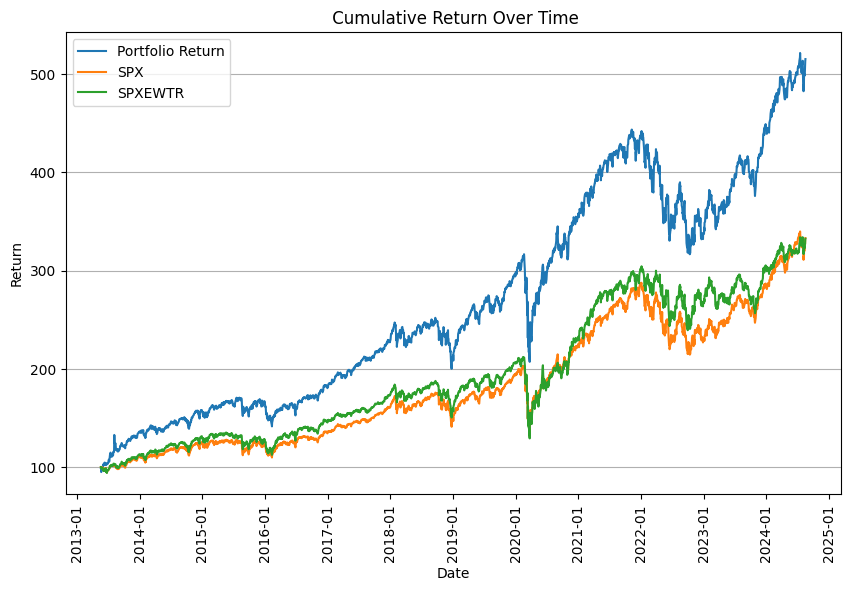

In [271]:
spx_file_path = r'C:/Users/Analyst/Desktop/SPX.csv'
spxewtr_file_path = r'C:/Users/Analyst/Desktop/SPXEWTR.csv'

spx = pd.read_csv(spx_file_path)
spxewtr = pd.read_csv(spxewtr_file_path)
spx.set_index('TRADE_DATE', inplace=True)
spxewtr.set_index('TRADE_DATE', inplace=True)
id = pd.DataFrame()
id.index = spx.index
id['SPX'] = spx['CLOSE']/spx['PRE_CLOSE']
id['SPXEWTR'] = spxewtr['CLOSE']/spxewtr['PRE_CLOSE']
id['Cumulative_SPX'] = id['SPX'].cumprod()
id['Cumulative_SPXEWTR'] = id['SPXEWTR'].cumprod()
id.index = pd.to_datetime(id.index)
id['Portfolio'] = return_result['Return']
id['Cumulative_Portfolio'] = return_result['Return'].cumprod()
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(id.index, id['Cumulative_Portfolio']*100, linestyle='-', label = 'Portfolio Return')
plt.plot(id.index, id['Cumulative_SPX']*100, linestyle='-', label = 'SPX')
plt.plot(id.index, id['Cumulative_SPXEWTR']*100, linestyle='-', label = 'SPXEWTR')

# Adding labels and title
plt.title(' Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Return')


plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # or mdates.MonthLocator() for monthly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend()

plt.xticks(rotation=90)
plt.grid(axis='y')

 # Show the plot
plt.show()

## **S&P 500 Performance Statistics**

In [273]:
spx_annual_return = (id['Cumulative_SPX'].iloc[-1]/id['Cumulative_SPX'].iloc[0]) ** (1/((id.index[-1]-id.index[0]).days/365))-1
spx_daily_volatility = id['SPX'].std()
spx_annual_volatility = spx_daily_volatility * np.sqrt(252)
spx_sharpe_ratio = (spx_annual_return-0.01)/spx_annual_volatility

print(f'SPX Annual Return: {spx_annual_return*100:.2f}%')
print(f'SPX Annual Volatitliy: {spx_annual_volatility*100:.2f}%')
print(f'SPX Sharpe Ratio: {spx_sharpe_ratio:.2f}')

SPX Annual Return: 11.30%
SPX Annual Volatitliy: 17.18%
SPX Sharpe Ratio: 0.60


## **S&P 500 Equal Weighted Performance Statistics**

In [274]:
spxew_annual_return = (id['Cumulative_SPXEWTR'].iloc[-1]/id['Cumulative_SPXEWTR'].iloc[0]) ** (1/((id.index[-1]-id.index[0]).days/365))-1
spxew_daily_volatility = id['SPXEWTR'].std()
spxew_annual_volatility = spxew_daily_volatility * np.sqrt(252)
spxew_sharpe_ratio = (spxew_annual_return-0.01)/spxew_annual_volatility
spxew_excess_return = spxew_annual_return-spx_annual_return
spxew_tracking_error = (id['SPXEWTR']-id['SPX']).std() * np.sqrt(252)
spxew_information_ratio = (spxew_annual_return-spx_annual_return)/spxew_tracking_error

print(f'SPX EW Annual Return: {spxew_annual_return*100:.2f}%')
print(f'SPX EW Annual Volatitliy: {spxew_annual_volatility*100:.2f}%')
print(f'SPX EW Sharpe Ratio: {spxew_sharpe_ratio:.2f}')
print(f'SPX EW Excess Return: {spxew_excess_return*100:.2f}%')
print(f'SPX EW Tracking Error: {spxew_tracking_error*100:.2f}%')
print(f'SPX EW Information Ratio: {spxew_information_ratio*100:.2f}%')

SPX EW Annual Return: 11.27%
SPX EW Annual Volatitliy: 17.81%
SPX EW Sharpe Ratio: 0.58
SPX EW Excess Return: -0.03%
SPX EW Tracking Error: 5.26%
SPX EW Information Ratio: -0.48%


## **Portfolio Performance Statistics**

In [275]:
annual_return = (return_result['Cumulative_Return'].iloc[-1]/return_result['Cumulative_Return'].iloc[0]) ** (1/((return_result.index[-1]-return_result.index[0]).days/365))-1
daily_volatility = return_result['Return'].std()
annual_volatility = daily_volatility * np.sqrt(252)
sharpe_ratio = (annual_return-0.01)/annual_volatility
excess_return = (annual_return-spx_annual_return)
tracking_error = (return_result['Return']-id['SPX']).std() * np.sqrt(252)
information = (annual_return-spx_annual_return)/tracking_error


print(f'Annual Return: {annual_return*100:.2f}%')
print(f'Annual Volatitliy: {annual_volatility*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Excess Return: {excess_return*100:.2f}%')
print(f'Tracking Error: {tracking_error*100:.2f}%')
print(f'Information Ratio:{information*100:.2f}%')

Annual Return: 15.81%
Annual Volatitliy: 19.05%
Sharpe Ratio: 0.78
Excess Return: 4.51%
Tracking Error: 7.05%
Information Ratio:63.98%


## **Monthly Return**

Mean Return: 0.013187439976371073
Standard Deviation: 0.0460735062234979
Skewness: -0.4361768812204014
Kurtosis: 0.946121651027084
95% Value at Risk: -0.07242314705670777
95% Conditional Value at Risk: -0.09763856031327836


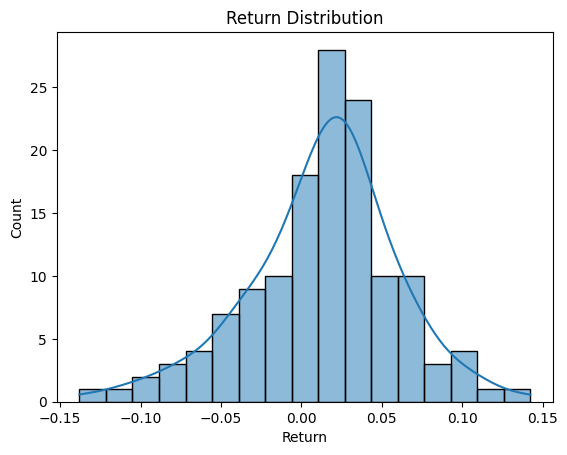

Normality test p-value: 0.018907707737560425


In [293]:
monthly_ret = pd.DataFrame(return_result['Return'].resample('1M',label = 'right').prod())
monthly_ret['Return'] = monthly_ret['Return']-1
# Calculate basic statistics
mean_return = monthly_ret['Return'].mean()
std_dev = monthly_ret['Return'].std()
skewness = monthly_ret['Return'].skew()
kurtosis = monthly_ret['Return'].kurt()

# Print the basic statistics
print(f"Mean Return: {mean_return}")
print(f"Standard Deviation: {std_dev}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

# Value at Risk (VaR) calculation at 95% confidence level
VaR_95 = np.percentile(monthly_ret['Return'], 5)
print(f"95% Value at Risk: {VaR_95}")

# Conditional Value at Risk (CVaR) calculation
CVaR_95 = monthly_ret[monthly_ret['Return'] <= VaR_95]['Return'].mean()
print(f"95% Conditional Value at Risk: {CVaR_95}")

# Plotting the return distribution
sns.histplot(monthly_ret['Return'], kde=True)
plt.title('Return Distribution')
plt.show()

# Check for normality
k2, p = stats.normaltest(monthly_ret['Return'])
print(f"Normality test p-value: {p}")

### **Portfolio Returns Heatmap**

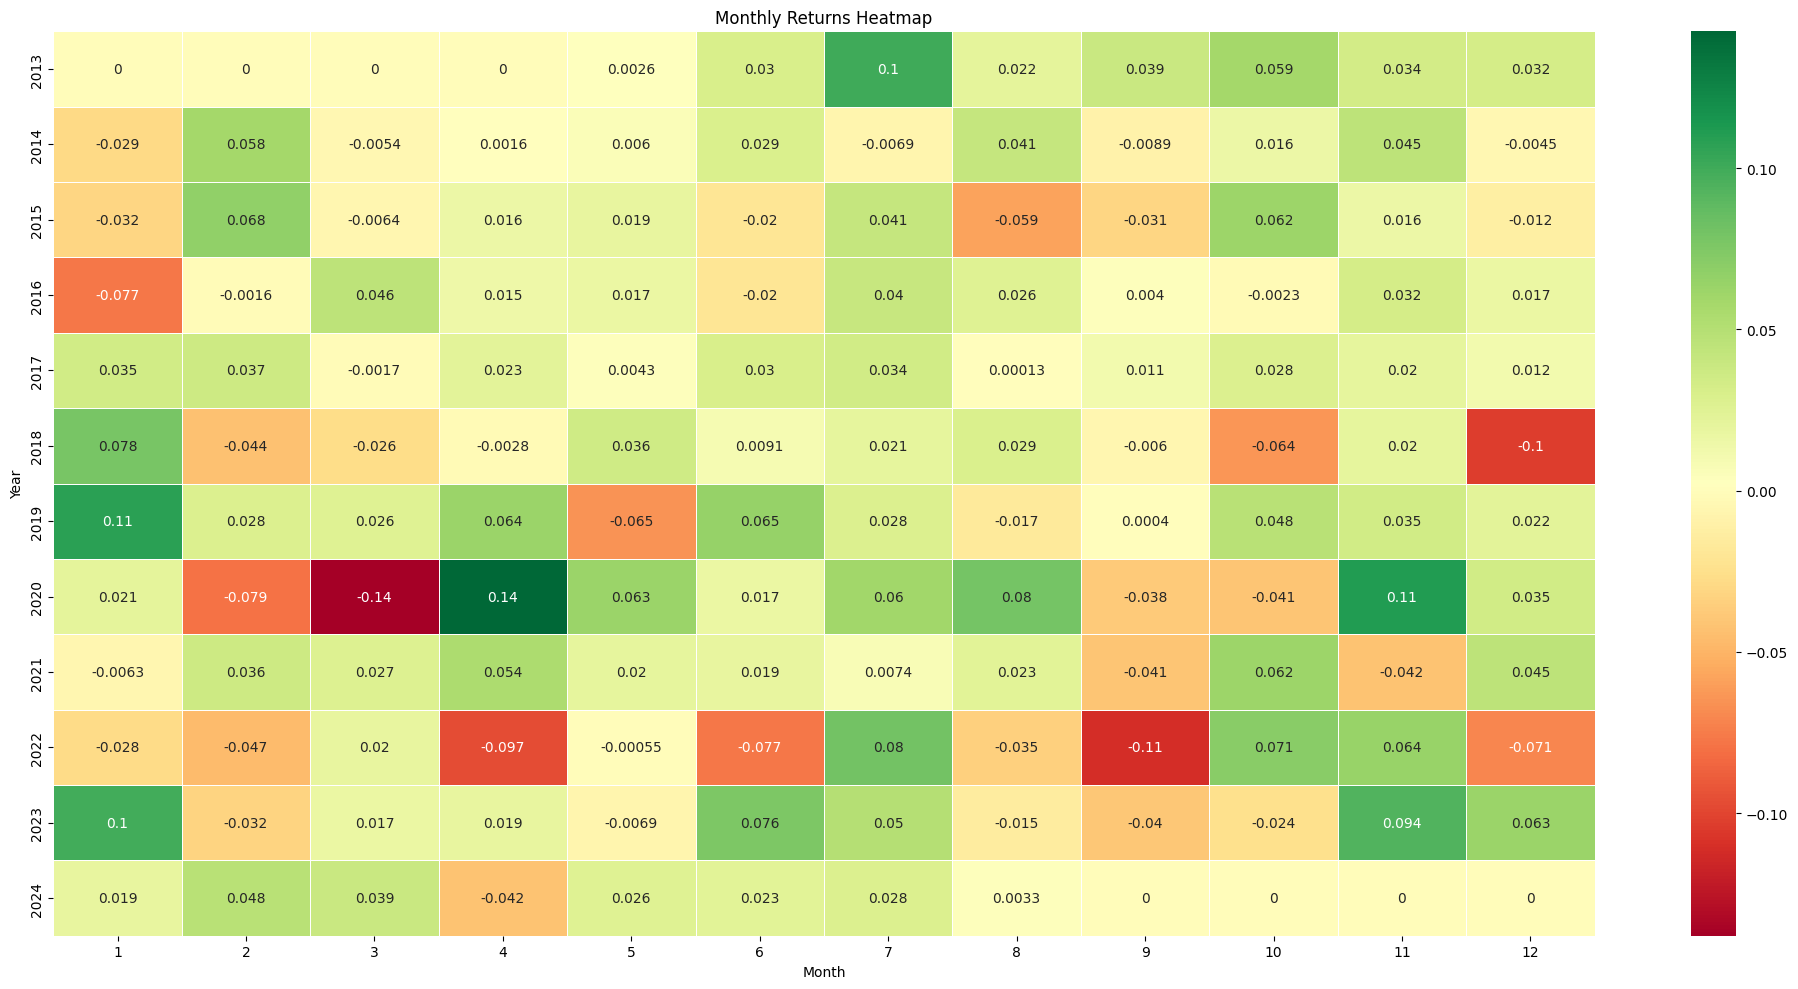

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt



# Step 1: Create 'Year' and 'Week' columns
monthly_ret['Year'] = monthly_ret.index.year
monthly_ret['Month'] = monthly_ret.index.month

# Step 2: Pivot the DataFrame
heatmap_data = monthly_ret.pivot_table(index='Year', columns='Month', values='Return', aggfunc='mean')
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce').fillna(0)
# Step 3: Plot the heatmap
plt.figure(figsize=(20, 10))  # Increase the figure size
sns.heatmap(heatmap_data, annot=True, linewidth=.5, cmap='RdYlGn')


# Adding titles and labels
plt.title('Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout() 
plt.show()

### **S&P Returns Heatmap**

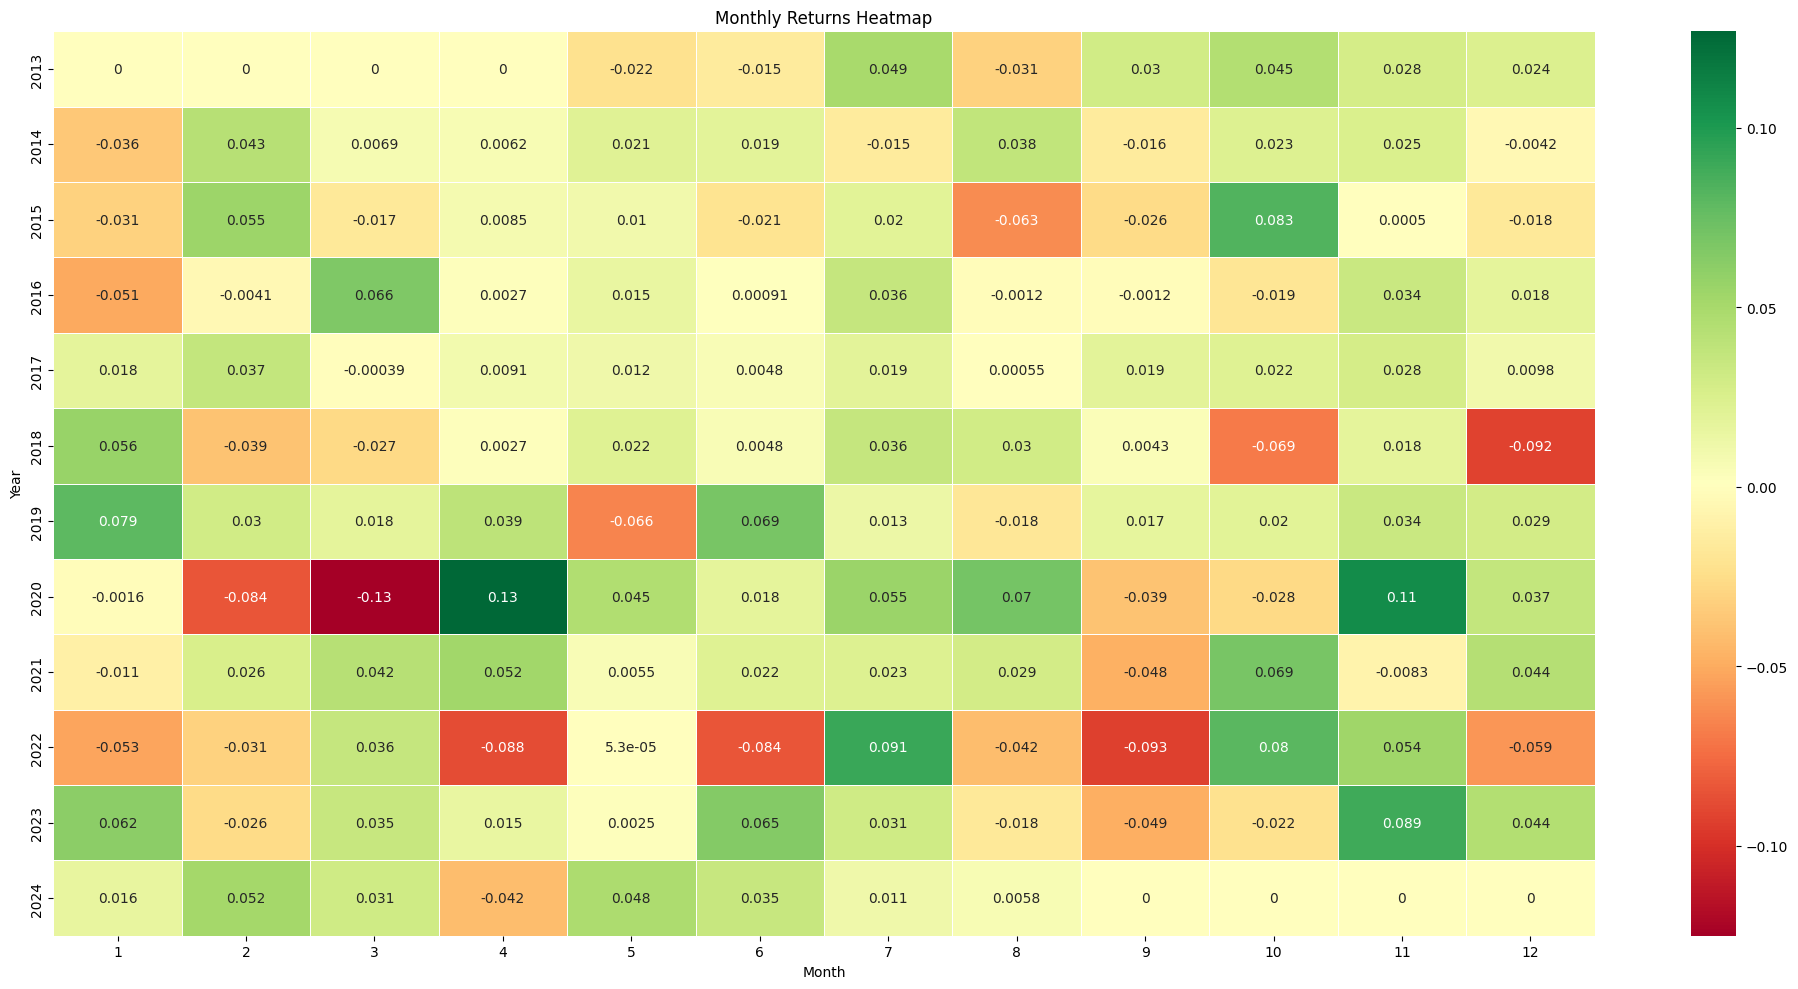

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt


spx_monthly_ret = pd.DataFrame(id['SPX'].resample('1M',label = 'right').prod())
spx_monthly_ret['SPX'] = spx_monthly_ret['SPX']-1
# Step 1: Create 'Year' and 'Week' columns
spx_monthly_ret['Year'] = spx_monthly_ret.index.year
spx_monthly_ret['Month'] = spx_monthly_ret.index.month

# Step 2: Pivot the DataFrame
spx_heatmap_data = spx_monthly_ret.pivot_table(index='Year', columns='Month', values='SPX', aggfunc='mean')
spx_heatmap_data = spx_heatmap_data.apply(pd.to_numeric, errors='coerce').fillna(0)
# Step 3: Plot the heatmap
plt.figure(figsize=(20, 10))  # Increase the figure size
sns.heatmap(spx_heatmap_data, annot=True, linewidth=.5, cmap='RdYlGn')


# Adding titles and labels
plt.title('Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout() 
plt.show()

In [300]:
combined_df = pd.DataFrame()
combined_df =pd.concat([monthly_ret['Return'],spx_monthly_ret['SPX']], axis =1)
combined_df.corr()

,Return,SPX
Return,1.000000,0.950476
SPX,0.950476,1.000000


### **Monthly Fama-French 6 factors**

In [301]:
ff5_file_path = r'C:/Users/Analyst/Desktop/F-F_Research_Data_5_Factors_2x3.csv'
mom_file_path = r'C:/Users/Analyst/Desktop/F-F_Momentum_Factor.csv'

ff5_df = pd.read_csv(ff5_file_path, skiprows = 3)
mom_df = pd.read_csv(mom_file_path, skiprows = 13)

ff5_df = ff5_df.dropna()
mom_df = mom_df.drop(columns = ['Unnamed: 2'])
mom_df = mom_df.dropna()

ff5_df['Date'] = pd.to_datetime(ff5_df['Unnamed: 0'], format='%Y%m')
ff5_df.set_index('Date', inplace = True)

mom_df['Date'] = pd.to_datetime(mom_df['Unnamed: 0'], format='%Y%m')
mom_df.set_index('Date', inplace = True)

# Drop the original date columns that are no longer needed
ff5_df = ff5_df.drop(columns=['Unnamed: 0'])
mom_df = mom_df.drop(columns=['Unnamed: 0'])
mom_df.columns = ['MOM']
ff6_df_monthly = pd.merge(ff5_df, mom_df, right_index=True, left_index=True, how='inner')
ff6_df_monthly.index = ff6_df_monthly.index.to_period('M')
monthly_ret.index = monthly_ret.index.to_period('M')

In [302]:
combined_df = pd.merge(monthly_ret*100, ff6_df_monthly, left_index=True, right_index=True, how='inner')
# Calculate the excess returns
combined_df['Excess Return'] = combined_df['Return'] - combined_df['RF']
# Define the independent variables (Fama-French factors)
X = combined_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
X = sm.add_constant(X)  # Add a constant term for the intercept (alpha)

# Define the dependent variable (Excess Return)
y = combined_df['Excess Return']
# Run the regression
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     232.9
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           5.13e-66
Time:                        11:08:10   Log-Likelihood:                -228.78
No. Observations:                 134   AIC:                             471.6
Df Residuals:                     127   BIC:                             491.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1773      0.125      1.421      0.1

- **Constant (const):**

    This is the model’s intercept, representing the expected excess return when all factors are 0. The p-value (0.158) is not statistically significant, meaning the constant is not significantly different from zero.

- **Market Risk Premium (Mkt-RF):**

    The market risk premium is highly significant (p-value = 0.000), with a coefficient close to 1, meaning that for every 1% change in the market excess return, the portfolio's excess return increases by roughly 1.0136%. This suggests the portfolio moves almost in lockstep with the overall market.

- **SMB (Small Minus Big):**

    This factor represents the size premium (small-cap minus large-cap). The negative coefficient suggests that the portfolio tends to underperform when small-cap stocks outperform large-cap stocks. The p-value (0.017) shows this effect is statistically significant.

- **HML (High Minus Low):**

    This factor represents the value premium (value stocks minus growth stocks). A positive coefficient indicates the portfolio benefits from value stocks outperforming growth stocks, though the p-value (0.088) suggests this result is marginally significant.

- **RMW (Robust Minus Weak):**

    This factor captures the profitability premium (high-profitability firms minus low-profitability firms). The negative coefficient implies the portfolio tends to do worse when highly profitable firms outperform low-profitability firms. However, the p-value (0.101) indicates that this effect is not statistically significant.

- **CMA (Conservative Minus Aggressive):**

    This factor reflects the investment premium (conservative firms that invest less versus aggressive firms that invest more). The negative coefficient suggests underperformance when conservative firms outperform. However, this result is not statistically significant (p-value = 0.206).

- **MOM (Momentum):**

    The momentum factor measures the performance of recent winners minus recent losers. The negative coefficient suggests the portfolio slightly underperforms during periods when momentum stocks (recent winners) outperform. However, the p-value (0.693) indicates this effect is not statistically significant.

In summary, the portfolio is highly correlated with market movements and large-cap stocks, while factors like profitability, investment behavior, and momentum have little to no significant effect on its performance.

## **Weekly Return**

### **Weekly Fama-French 6 factors**

In [ ]:
weekly_ret = pd.DataFrame(return_result['Return'].resample('W-FRI',label = 'right').prod())
weekly_ret = (weekly_ret-1)*100

ff5_file_path = r'C:/Users/Analyst/Desktop/F-F_Research_Data_5_Factors_2x3_daily.csv'
mom_file_path = r'C:/Users/Analyst/Desktop/F-F_Momentum_Factor_daily.csv'

ff5_df = pd.read_csv(ff5_file_path, skiprows = 3)
mom_df = pd.read_csv(mom_file_path, skiprows = 13)

ff5_df = ff5_df.dropna()
mom_df = mom_df.dropna()

ff5_df['Date'] = pd.to_datetime(ff5_df['Unnamed: 0'], format='%Y%m%d')
ff5_df.set_index('Date', inplace = True)

mom_df['Date'] = pd.to_datetime(mom_df['Unnamed: 0'], format='%Y%m%d')
mom_df.set_index('Date', inplace = True)

# Drop the original date columns that are no longer needed
ff5_df = ff5_df.drop(columns=['Unnamed: 0'])
mom_df = mom_df.drop(columns=['Unnamed: 0'])
mom_df.columns = ['MOM']

ff6_df_weekly = pd.merge(ff5_df, mom_df, right_index=True, left_index=True, how='inner')
factors_cum = 1+ff6_df_weekly/100
factors_cum = factors_cum.cumprod()

factors_cum_w = factors_cum.resample('W-FRI').last().fillna(method = 'ffill')
factors_w = (factors_cum_w/factors_cum_w.shift()-1)*100
factors_w.dropna(inplace = True)

In [304]:
combined_df = pd.merge(weekly_ret, factors_w, left_index=True, right_index=True, how='inner')
# Calculate the excess returns
combined_df['Excess Return'] = combined_df['Return'] - combined_df['RF']
# Define the independent variables (Fama-French factors)
X = combined_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
X = sm.add_constant(X)  # Add a constant term for the intercept (alpha)

# Define the dependent variable (Excess Return)
y = combined_df['Excess Return']
# Run the regression
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     989.6
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          1.40e-298
Time:                        11:08:14   Log-Likelihood:                -639.24
No. Observations:                 580   AIC:                             1292.
Df Residuals:                     573   BIC:                             1323.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0455      0.031      1.479      0.1

- **Constant (const):**

    This represents the average excess return when all factors are at zero. The p-value (0.140) indicates that this intercept is not statistically significant.

- **Mkt-RF (Market Risk Premium):**

    This suggests that for every 1% change in the market risk premium, the excess return of the portfolio increases by about 1.01%. The coefficient is very close to 1, indicating the portfolio's returns move nearly in sync with the market. The p-value (0.000) shows this factor is highly significant.

- **SMB (Small Minus Big):**

    The negative coefficient implies the portfolio tends to favor larger stocks, as it performs worse when small-cap stocks outperform large-cap stocks. The p-value (0.000) indicates this factor is statistically significant.

- **HML (High Minus Low):**

    This positive coefficient shows the portfolio benefits from value stocks outperforming growth stocks. The p-value (0.000) indicates strong statistical significance, meaning the portfolio has a tilt toward value investing.

- **RMW (Robust Minus Weak):**

    The negative coefficient suggests that the portfolio underperforms when highly profitable companies outperform less profitable ones. However, the p-value (0.212) indicates this result is not statistically significant.

- **CMA (Conservative Minus Aggressive):**

    This negative coefficient shows that the portfolio underperforms when firms that invest conservatively (low-investment firms) outperform aggressive investors (high-investment firms). The p-value (0.018) shows this factor is statistically significant.

- **MOM (Momentum):**

    The negative coefficient suggests the portfolio performs slightly worse when momentum stocks (recent winners) outperform. However, the p-value (0.802) indicates that this result is not statistically significant.

The portfolio’s weekly performance is heavily driven by the market, with smaller but significant influences from the size (SMB), value (HML), and investment (CMA) factors. The size factor shows that the portfolio tilts towards large-cap stocks, while the value factor indicates a preference for value stocks. Profitability and momentum do not significantly impact the portfolio, based on these results.

## **Weekly Value at Risk**

### **Historical Method VaR**

Mean Return: 0.31%
Standard Deviation: 2.45%
Skewness: -0.41
Kurtosis: 6.27
95% Value at Risk: -3.38%
95% Conditional Value at Risk: -5.52%


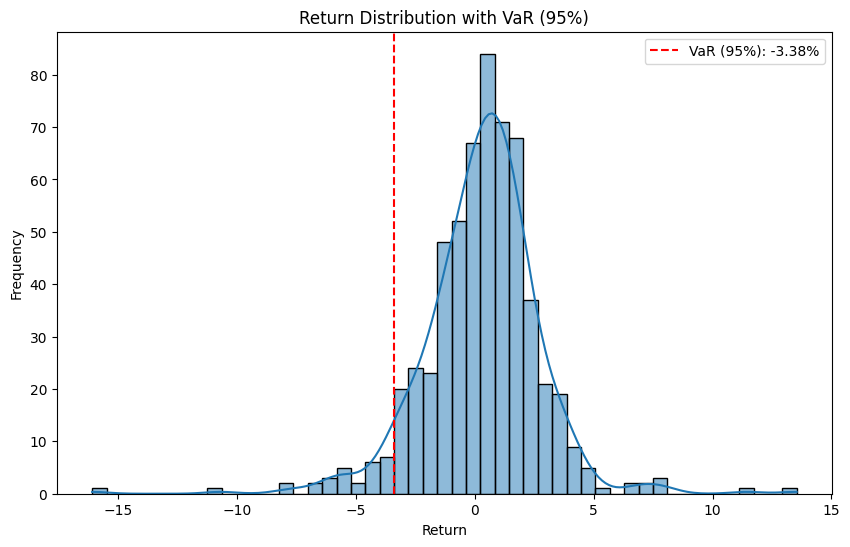

Normality test p-value: 1.8987263308767384e-22


In [305]:
# Calculate basic statistics
mean_return = weekly_ret['Return'].mean()
std_dev = weekly_ret['Return'].std()
skewness = weekly_ret['Return'].skew()
kurtosis = weekly_ret['Return'].kurt()

# Print the basic statistics
print(f"Mean Return: {mean_return:.2f}%")
print(f"Standard Deviation: {std_dev:.2f}%")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

# Value at Risk (VaR) calculation at 95% confidence level
VaR_95 = np.percentile(weekly_ret['Return'], 5)
print(f"95% Value at Risk: {VaR_95:.2f}%")

# Conditional Value at Risk (CVaR) calculation
CVaR_95 = weekly_ret[weekly_ret['Return'] <= VaR_95]['Return'].mean()
print(f"95% Conditional Value at Risk: {CVaR_95:.2f}%")

# Plotting the return distribution with VaR annotation
plt.figure(figsize=(10,6))
sns.histplot(weekly_ret['Return'], kde=True)
plt.axvline(x=VaR_95, color='r', linestyle='--', label=f'VaR (95%): {VaR_95/100:.2%}')
plt.title('Return Distribution with VaR (95%)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

# Check for normality
k2, p = stats.normaltest(weekly_ret['Return'])
print(f"Normality test p-value: {p}")


**Null Hypothesis(H0): The data follows a normal distribution.**

**Alternative Hypothesis(H1): The data does not follow a normal distribution.**

The p-value is small enough to reject the null hypothesis, suggesting that the return data does not follow a normal distribution.

We need to find the proper distribution.

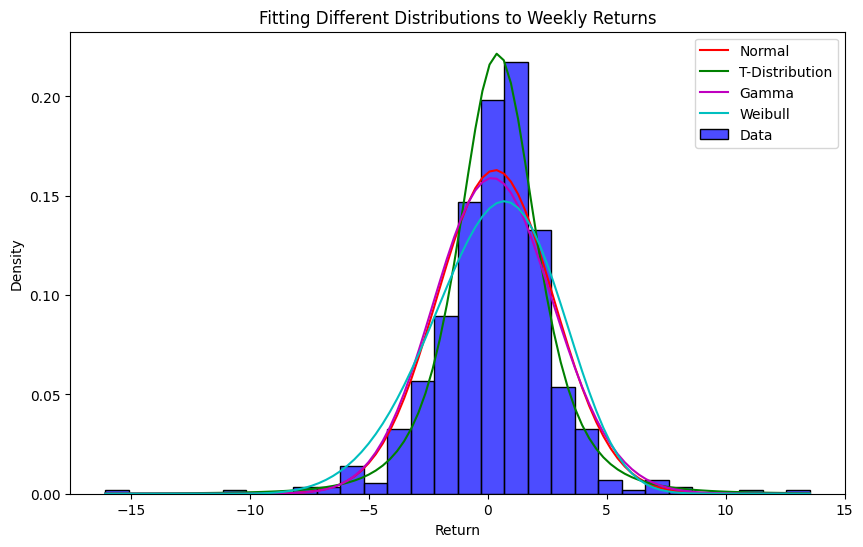

In [306]:
weekly_ret_mean = weekly_ret.mean()
weekly_ret_std = weekly_ret.std()


# Load your weekly returns data into a pandas DataFrame
# Assuming your data is already loaded in a DataFrame named 'weekly_ret'

# Fit different distributions
params_norm = norm.fit(weekly_ret['Return'])
params_t = t.fit(weekly_ret['Return'])
#params_lognorm = lognorm.fit(weekly_ret['Return'], floc=0)  # floc=0 to force lognorm fitting
params_gamma = gamma.fit(weekly_ret['Return'])
params_weibull = weibull_min.fit(weekly_ret['Return'])

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
sns.histplot(weekly_ret['Return'], bins=30, kde=False, stat='density', label='Data', color='blue', alpha=0.7)

# Plot the fitted distributions
x = np.linspace(weekly_ret['Return'].min(), weekly_ret['Return'].max(), 100)

plt.plot(x, norm.pdf(x, *params_norm), 'r-', label='Normal')
plt.plot(x, t.pdf(x, *params_t), 'g-', label='T-Distribution')
#plt.plot(x, lognorm.pdf(x, *params_lognorm), 'b-', label='Log-Normal')
plt.plot(x, gamma.pdf(x, *params_gamma), 'm-', label='Gamma')
plt.plot(x, weibull_min.pdf(x, *params_weibull), 'c-', label='Weibull')

# Adding titles and labels
plt.title('Fitting Different Distributions to Weekly Returns')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()

plt.show()


### **K-S test**

In [307]:
# Perform the K-S test for each distribution
ks_stat_norm, ks_pvalue_norm = kstest(weekly_ret['Return'], 'norm', args=params_norm)
ks_stat_t, ks_pvalue_t = kstest(weekly_ret['Return'], 't', args=params_t)
ks_stat_gamma, ks_pvalue_gamma = kstest(weekly_ret['Return'], 'gamma', args=params_gamma)

print("K-S Test Results:")
print(f"Normal:     Statistic = {ks_stat_norm:.4f}, p-value = {ks_pvalue_norm:.4f}")
print(f"T-Distrib:  Statistic = {ks_stat_t:.4f}, p-value = {ks_pvalue_t:.4f}")
print(f"Gamma:      Statistic = {ks_stat_gamma:.4f}, p-value = {ks_pvalue_gamma:.4f}")


K-S Test Results:
Normal:     Statistic = 0.0690, p-value = 0.0071
T-Distrib:  Statistic = 0.0255, p-value = 0.8295
Gamma:      Statistic = 0.0784, p-value = 0.0014


**Normal Distribution:**

- Statistic: The K-S statistic represents the maximum difference between the empirical distribution and the normal distribution. A smaller value suggests that the data is closer to the theoretical distribution.
- A p-value less than 0.05 indicates that the data significantly deviates from a normal distribution. In other words, there is strong evidence to reject the hypothesis that the data follows a normal distribution.

**T-Distribution:**

- Statistic: The smaller statistic suggests that the data is very close to the t-distribution.
- A high p-value (greater than 0.05) indicates that the data does not significantly deviate from the t-distribution. This means the data likely follows a t-distribution, as there is no evidence to reject the null hypothesis that the data fits this distribution.

**Gamma Distribution:**

- Statistic: The larger statistic indicates a noticeable deviation between the data and the gamma distribution.
- A very low p-value suggests that the data significantly deviates from a gamma distribution. Therefore, the null hypothesis that the data follows a gamma distribution is rejected.

### **AIC/BIC test**

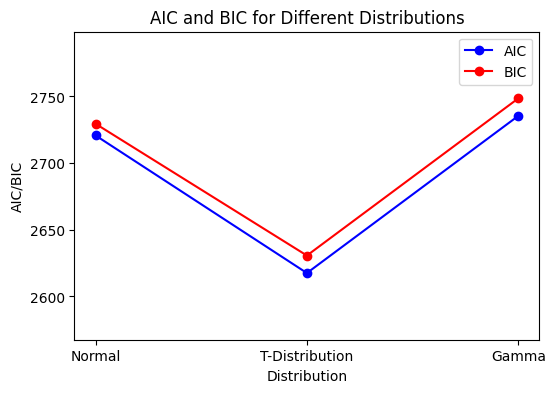

In [308]:
def calculate_aic_bic(log_likelihood, num_params, num_samples):
    """ Calculate AIC and BIC """
    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(num_samples) * num_params - 2 * log_likelihood
    return aic, bic

# Number of samples
n = len(weekly_ret['Return'])

# Fit the distributions and calculate log-likelihoods
distributions = {
    'Normal': norm,
    'T-Distribution': t,
    'Gamma': gamma
}

aic_values = []
bic_values = []
distribution_names = []

for name, distribution in distributions.items():
    if name == 'Log-Normal':
        params = distribution.fit(weekly_ret['Return'], floc=0)  # Log-Normal special case
    else:
        params = distribution.fit(weekly_ret['Return'])
    
    log_likelihood = np.sum(distribution.logpdf(weekly_ret['Return'], *params))
    aic, bic = calculate_aic_bic(log_likelihood, len(params), n)
    
    distribution_names.append(name)
    aic_values.append(aic)
    bic_values.append(bic)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(distribution_names, aic_values, marker='o', linestyle='-', color='blue', label='AIC')
plt.plot(distribution_names, bic_values, marker='o', linestyle='-', color='red', label='BIC')

# Adding titles and labels
plt.title('AIC and BIC for Different Distributions')
plt.xlabel('Distribution')
plt.ylabel('AIC/BIC')
plt.ylim([min(aic_values + bic_values) - 50, max(aic_values + bic_values) + 50])  # Adjust y-axis limits for better visualization
plt.legend()

# Show the plot
plt.show()


- **Normal Distribution:** Both AIC and BIC are relatively high for the normal distribution, suggesting it's not the best fit for the data.

- **T-Distribution:** The T-distribution has the lowest AIC and BIC values compared to the other distributions, which means it provides the best fit to the data among the three.

- **Gamma Distribution:** The AIC and BIC values are even higher for the gamma distribution than for the normal distribution, suggesting that the gamma distribution is the least suitable fit for this dataset.

**Conclusion:** The T-distribution is the most appropriate model for the data based on both AIC and BIC, as its values are significantly lower than the other two distributions.

### **Patametric Method**

### **Normal Distribution**

In [309]:
confidence_level = 0.95
z_score = norm.ppf(confidence_level)
var_95_par = weekly_ret_mean-(z_score * weekly_ret_std)
cvar_95_par = weekly_ret_mean - (weekly_ret_std / (1 - confidence_level)) * (norm.pdf(z_score))

print(f"VaR (95%) using Parametric Method: {var_95_par.item():.2f} %")
print(f"CVaR (95%) using Parametric Method: {cvar_95_par.item():.2f} %")

VaR (95%) using Parametric Method: -3.72 %
CVaR (95%) using Parametric Method: -4.74 %


### **T-distribution**

In [251]:
df, loc, scale = params_t

confidence_level = 0.95

# Step 1: Calculate the t-score (percent point function for t-distribution)
var_95_t = t.ppf(1-confidence_level, df, loc =weekly_ret_mean.item(), scale = weekly_ret_std.item())



cvar_95_t = t.expect(lambda x: x, lb=-float('inf'), ub=var_95_t, args=(df,), loc=weekly_ret_mean.item(), scale=weekly_ret_std.item()) / (1 - confidence_level)
# Print the results
print(f"VaR (95%) using t-distribution: {var_95_t.item():.2f} %")
print(f"CVaR (95%) using t-distribution: {cvar_95_t.item():.2f} %")

VaR (95%) using t-distribution: -5.04 %
CVaR (95%) using t-distribution: -7.88 %


### **Monte Carlo Method**

### **T-distribution Simulation**

VaR (95%) using T-distribution: -3.27%
CVaR (95%) using T-distribution: -5.19%


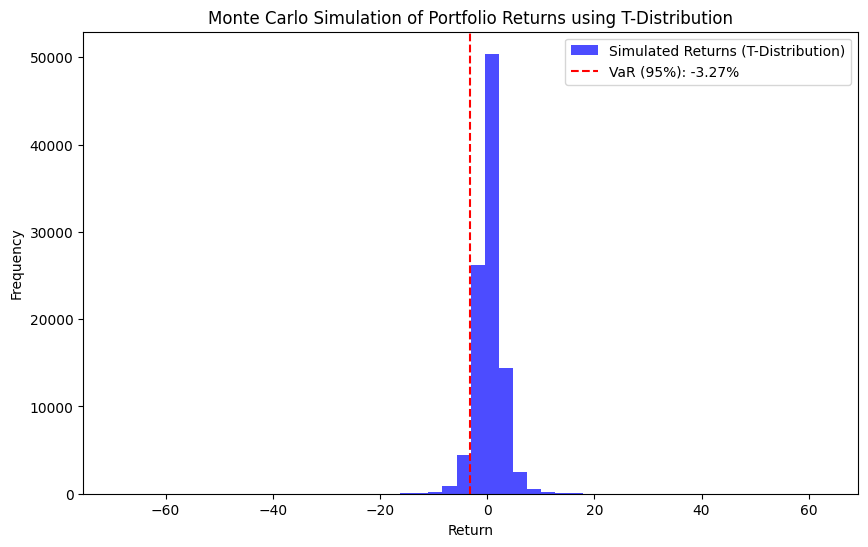

In [310]:
df, loc, scale = params_t  # Degrees of freedom, location, and scale parameters

# Step 2: Set up Monte Carlo Simulation
num_simulations = 100000  # Number of simulations
num_days = 1  # Adjust if you want to simulate for multiple days

# Generate random returns from the T-distribution
simulated_returns = t.rvs(df, loc=loc, scale=scale, size=(num_simulations, num_days))

# If you need cumulative returns over multiple days
# simulated_returns = np.cumprod(1 + simulated_returns, axis=1) - 1

# Step 3: Calculate Value at Risk (VaR) - for a 95% confidence level
confidence_level = 0.95
var_95_mon = np.percentile(simulated_returns, (1 - confidence_level) * 100)
cvar_95_mon = simulated_returns[simulated_returns <= var_95_mon].mean()


print(f"VaR (95%) using T-distribution: {var_95_mon/100:.2%}")
print(f"CVaR (95%) using T-distribution: {cvar_95_mon/100:.2%}")
# Step 4: Visualize the Simulated Returns
plt.figure(figsize=(10, 6))
plt.hist(simulated_returns, bins=50, color='blue', alpha=0.7, label='Simulated Returns (T-Distribution)')
plt.axvline(x=var_95_mon, color='red', linestyle='--', label=f'VaR (95%): {var_95_mon/100:.2%}')

plt.title('Monte Carlo Simulation of Portfolio Returns using T-Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### **All VaR Method**

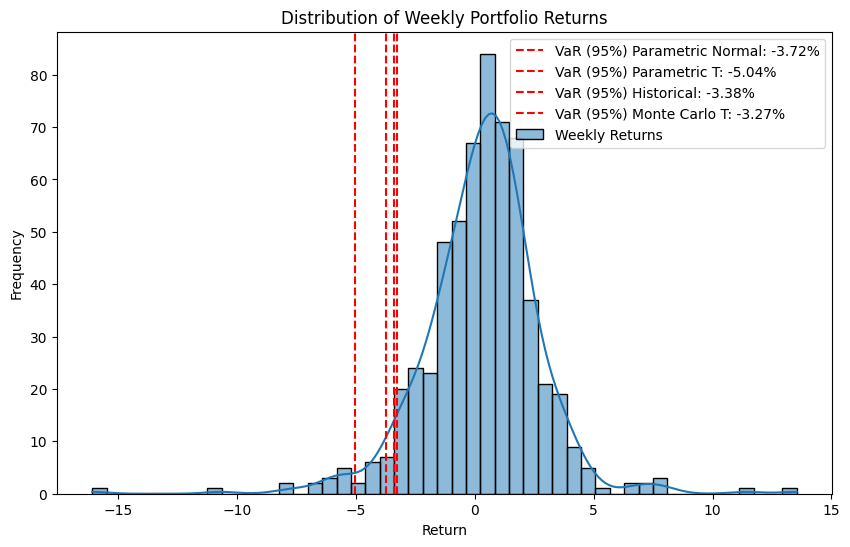

In [327]:


var_95_his = np.percentile(weekly_ret['Return'], 5)



plt.figure(figsize = (10,6))
sns.histplot(weekly_ret['Return'], kde=True, label = 'Weekly Returns')

plt.axvline(x=var_95_par.iloc[0],color = 'red', linestyle = '--', label=f'VaR (95%) Parametric Normal: {var_95_par.iloc[0]/100:.2%}')
plt.axvline(x=var_95_t.item(),color = 'red', linestyle = '--', label=f'VaR (95%) Parametric T: {var_95_t.item()/100:.2%}')
plt.axvline(x=var_95_his,color = 'red', linestyle = '--', label=f'VaR (95%) Historical: {var_95_his/100:.2%}')
plt.axvline(x=var_95_mon, color='red', linestyle='--', label=f'VaR (95%) Monte Carlo T: {var_95_mon/100:.2%}')



plt.title('Distribution of Weekly Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()


plt.show()

# **Risk Parity Portfolio**

In [312]:
df_weights_rp = df_weights.copy()

## **Calculate Risk Parity Weights**

In [313]:
# Assuming df_weights_rp has columns 'TICKER', 'BUY_DATE', and 'WEIGHT'
risk_weighted_portfolio = []
min_trading_days = 240  # Minimum number of trading days to consider

df_weights_rp['RP_Weight'] = np.nan
df_weights_rp['Risk_Contribution'] = np.nan
risk_contributions = pd.DataFrame()

for period in df_weights_rp['PERIOD'].unique():
    # Skip periods before 2013-12-31
    if period < pd.Timestamp('2013-12-31'):
        continue

    period_data = df_weights_rp[df_weights_rp['PERIOD'] == period]
    portfolio_return = pd.DataFrame()
    
    valid_rows = []
    for i, row in period_data.iterrows():
        ticker = row['TICKER']
        buy_date = row['BUY_DATE']
        
        # Filter the price data for the one-year period before the buy_date
        start_date = buy_date - pd.DateOffset(years=1)
        price_data = df_prices[(df_prices['TICKER'] == ticker) & 
                               (df_prices.index >= start_date) & 
                               (df_prices.index <= buy_date)]
        
        # Ensure there are enough data points (at least 252 trading days)
        if len(price_data) < min_trading_days:
            print(f"Skipping {ticker} for period {period} due to insufficient data.")
            continue
        portfolio_return[ticker] = price_data['Return']-1
    sigma = portfolio_return.cov()
    b = [1/ portfolio_return.shape[1] for _ in range(portfolio_return.shape[1])]
    w = rp.vanilla.design(sigma, b)
    rc = w @ (sigma * w)
    rc_normalized = rc / np.sum(rc)

    for i, ticker in enumerate(portfolio_return.columns):
            df_weights_rp.loc[(df_weights_rp['PERIOD'] == period) & (df_weights_rp['TICKER'] == ticker), 'RP_Weight'] = w[i]
            df_weights_rp.loc[(df_weights_rp['PERIOD'] == period) & (df_weights_rp['TICKER'] == ticker), 'Risk_Contribution'] = rc_normalized.iloc[i]




Skipping CHK for period 2013-12-31 00:00:00 due to insufficient data.
Skipping CHK for period 2014-03-31 00:00:00 due to insufficient data.
Skipping CHK for period 2014-06-30 00:00:00 due to insufficient data.
Skipping COV for period 2014-12-31 00:00:00 due to insufficient data.
Skipping DTV for period 2015-06-30 00:00:00 due to insufficient data.
Skipping KHC for period 2015-09-30 00:00:00 due to insufficient data.
Skipping PYPL for period 2015-12-31 00:00:00 due to insufficient data.
Skipping KHC for period 2015-12-31 00:00:00 due to insufficient data.
Skipping PYPL for period 2016-03-31 00:00:00 due to insufficient data.
Skipping KHC for period 2016-03-31 00:00:00 due to insufficient data.
Skipping BAM for period 2016-06-30 00:00:00 due to insufficient data.
Skipping BAM for period 2016-09-30 00:00:00 due to insufficient data.
Skipping BAM for period 2016-12-31 00:00:00 due to insufficient data.
Skipping LILAK for period 2018-03-31 00:00:00 due to insufficient data.
Skipping LVNTA f

In [314]:
df_weights_rp = df_weights_rp.dropna()
df_weights_rp

,CUSIP,ManagerCount,PERIOD,BUY_DATE,SELL_DATE,TICKER,RP_Weight,Risk_Contribution
0,594918104,46,2024-03-31,2024-05-20,2024-08-16,MSFT,0.020909,0.023266
1,02079K305,42,2024-03-31,2024-05-20,2024-08-16,GOOGL,0.018039,0.023271
2,02079K107,35,2024-03-31,2024-05-20,2024-08-16,GOOG,0.018088,0.023273
3,92826C839,29,2024-03-31,2024-05-20,2024-08-16,V,0.027100,0.023266
4,30303M102,29,2024-03-31,2024-05-20,2024-08-16,META,0.015140,0.023271
...,...,...,...,...,...,...,...,...
1899,536797103,8,2023-12-31,2024-02-20,2024-05-17,LAD,0.014140,0.024394
1900,02005N100,8,2023-12-31,2024-02-20,2024-05-17,ALLY,0.013287,0.024395
1901,98138H101,8,2023-12-31,2024-02-20,2024-05-17,WDAY,0.019538,0.024398
1902,806857108,8,2023-12-31,2024-02-20,2024-05-17,SLB,0.022365,0.024397


## **Calculating Portfolio Return**

In [ ]:
import pandas as pd

# Function to calculate the periodic return for each stock
def calculate_periodic_return(df, ticker, start_date, end_date):
    # Filter the price data for the given ticker and date range
    df_filtered = df[(df['TICKER'] == ticker) & 
                     (df.index >= start_date) & 
                     (df.index <= end_date)]
    
    # Ensure that both start and end dates exist in the filtered data
    if start_date in df_filtered.index and end_date in df_filtered.index:
        # Return the series of daily returns for the specified period
        return df_filtered['Return']
    else:
        # Return an empty series if the condition is not met
        return pd.Series(dtype='float64')

# Initialize a list to store portfolio returns for each period
portfolio_returns_list = []

# Group df_weights by PERIOD
grouped_weights = df_weights.groupby('PERIOD')

for period, group in grouped_weights:
    # Initialize a DataFrame to store the stock returns for the current period
    period_stock_returns = pd.DataFrame()
    
    for _, row in group.iterrows():
        ticker = row['TICKER']
        start_date = row['BUY_DATE']
        end_date = row['SELL_DATE']
        
        # Calculate the periodic return for the ticker
        period_return = calculate_periodic_return(df_prices, ticker, start_date, end_date)
        if not period_return.empty:
            # Store the stock's return series in the period_stock_returns DataFrame
            period_stock_returns[ticker] = period_return
    
    # Calculate the portfolio return for the period by averaging the stock returns
    if not period_stock_returns.empty:
        portfolio_return = period_stock_returns.mean(axis=1)
        
        # Add the portfolio return series to the list
        portfolio_returns_list.append(portfolio_return)

# Combine all the portfolio returns into a single Series
portfolio_returns_df = pd.concat(portfolio_returns_list)

# Create a DataFrame for the portfolio returns
return_result = pd.DataFrame(portfolio_returns_df, columns=['Return'])

# Calculate the cumulative return
return_result['Cumulative_Return'] = return_result['Return'].cumprod()

# Define the cutoff date
cutoff_date = pd.to_datetime("2024-08-16")

# Drop rows where the index (date) is greater than the cutoff date
return_result = return_result[return_result.index <= cutoff_date]

# Display the final result
return_result


In [328]:
# Function to calculate the periodic return for each stock
def calculate_periodic_return(df, ticker, start_date, end_date):
    # Filter the price data for the given ticker and date range
    df_filtered = df[(df['TICKER'] == ticker) & 
                     (df.index >= start_date) & 
                     (df.index <= end_date)]
    if start_date in df_filtered.index and end_date in df_filtered.index:
        # Return the series of daily returns for the specified period
        return df_filtered['Return']
    else:
        return pd.Series(dtype='float64')

# Initialize a DataFrame to store portfolio returns for each period
rp_portfolio_returns_list = []

# Group df_weights by PERIOD
grouped_weights = df_weights_rp.groupby('PERIOD')

for period, group in grouped_weights:
    # Initialize a DataFrame to store the stock returns for the current period
    period_stock_returns = pd.DataFrame()
    
    for _, row in group.iterrows():
        ticker = row['TICKER']
        start_date = row['BUY_DATE']
        end_date = row['SELL_DATE']
        
        # Calculate the periodic return for the ticker
        period_return = calculate_periodic_return(df_prices, ticker, start_date, end_date)
        if period_return is not None:
            # Store the stock's return series in the period_stock_returns DataFrame
            period_stock_returns[ticker] = period_return
    
    # Calculate the portfolio return for the period by averaging the stock returns
    if not period_stock_returns.empty:
        portfolio_return = period_stock_returns.mean(axis=1)
        
        # Add the portfolio return series to the portfolio_returns_df
        rp_portfolio_returns_list.append(portfolio_return)

# Combine all the portfolio returns into a single Series
rp_portfolio_returns_df = pd.concat(rp_portfolio_returns_list)

# Create a DataFrame for the portfolio returns
rp_return_result = pd.DataFrame(rp_portfolio_returns_df, columns=['Return'])

# Calculate the cumulative return
rp_return_result['Cumulative_Return'] = rp_return_result['Return'].cumprod()

# Define the cutoff date
cutoff_date = pd.to_datetime("2024-08-16")

# Drop rows where the index (date) is greater than the cutoff date
rp_return_result = rp_return_result[rp_return_result.index <= cutoff_date]

# Display the final result
rp_return_result



,Return,Cumulative_Return
Date,,
2014-02-19,0.990134,0.990134
2014-02-20,1.004879,0.994965
2014-02-21,0.998626,0.993598
2014-02-24,1.007949,1.001496
2014-02-25,1.000278,1.001775
...,...,...
2024-08-12,0.996754,3.583015
2024-08-13,1.010375,3.620187
2024-08-14,1.004789,3.637523


## **Perfomance**

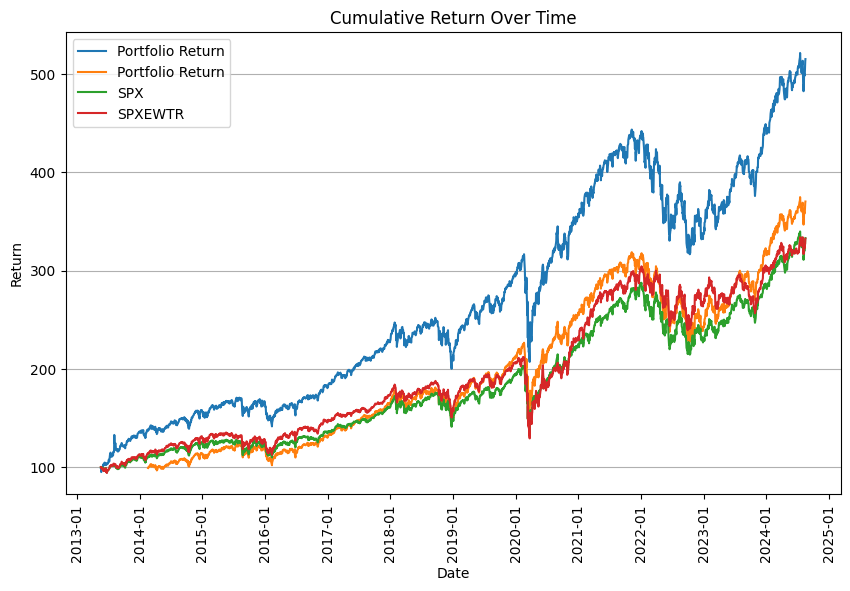

In [329]:
id['RP_Portfolio'] = rp_return_result['Return']
id['RP_Cumulative_Portfolio'] = rp_return_result['Return'].cumprod()
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(id.index, id['Cumulative_Portfolio']*100, linestyle='-', label = 'Portfolio Return')
plt.plot(id.index, id['RP_Cumulative_Portfolio']*100, linestyle='-', label = 'Portfolio Return')
plt.plot(id.index, id['Cumulative_SPX']*100, linestyle='-', label = 'SPX')
plt.plot(id.index, id['Cumulative_SPXEWTR']*100, linestyle='-', label = 'SPXEWTR')

# Adding labels and title
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Return')


plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # or mdates.MonthLocator() for monthly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend()

plt.xticks(rotation=90)
plt.grid(axis='y')

 # Show the plot
plt.show()

In [330]:
rp_annual_return = (rp_return_result['Cumulative_Return'].iloc[-1]/rp_return_result['Cumulative_Return'].iloc[0]) ** (1/((rp_return_result.index[-1]-rp_return_result.index[0]).days/365))-1
rp_annual_volatility = rp_return_result['Return'].std()*np.sqrt(252)
rp_sharpe_ratio = (rp_annual_return.mean()*100-1)/(rp_annual_volatility.mean()*100)
rp_excess_return = rp_annual_return.mean()-spx_annual_return
rp_tracking_error = (rp_return_result['Return']-id['SPX']).std() * np.sqrt(252)
rp_information_ratio = (rp_annual_return.mean()-spx_annual_return)/rp_tracking_error
print(f'Risk Parity Annual Return: {rp_annual_return.mean()*100:.2f} %')
print(f'Risk Parity Annual Volatility: {rp_annual_volatility.mean()*100:.2f}%')
print(f'Risk Parity Sharpe Ratio: {rp_sharpe_ratio:.2f}')
print(f'Risk Parity Excess Return: {rp_excess_return*100:.2f}%')
print(f'Risk Parity Tracking Error: {rp_tracking_error*100:.2f}%')
print(f'Risk Parity Information Ratio: {rp_information_ratio*100:.2f}%')

Risk Parity Annual Return: 13.39 %
Risk Parity Annual Volatility: 18.67%
Risk Parity Sharpe Ratio: 0.66
Risk Parity Excess Return: 2.10%
Risk Parity Tracking Error: 4.46%
Risk Parity Information Ratio: 47.05%


## **Weekly Fama_French 6 factors**

In [318]:
rp_weekly_ret = pd.DataFrame(rp_return_result['Return'].resample('W-FRI',label = 'right').prod())
rp_weekly_ret = (rp_weekly_ret-1)*100

In [ ]:
ff5_file_path = r'C:/Users/Analyst/Desktop/F-F_Research_Data_5_Factors_2x3_daily.csv'
mom_file_path = r'C:/Users/Analyst/Desktop/F-F_Momentum_Factor_daily.csv'

ff5_df = pd.read_csv(ff5_file_path, skiprows = 3)
mom_df = pd.read_csv(mom_file_path, skiprows = 13)

ff5_df = ff5_df.dropna()
mom_df = mom_df.dropna()

ff5_df['Date'] = pd.to_datetime(ff5_df['Unnamed: 0'], format='%Y%m%d')
ff5_df.set_index('Date', inplace = True)

mom_df['Date'] = pd.to_datetime(mom_df['Unnamed: 0'], format='%Y%m%d')
mom_df.set_index('Date', inplace = True)

# Drop the original date columns that are no longer needed
ff5_df = ff5_df.drop(columns=['Unnamed: 0'])
mom_df = mom_df.drop(columns=['Unnamed: 0'])
mom_df.columns = ['MOM']
ff6_df_weekly = pd.merge(ff5_df, mom_df, right_index=True, left_index=True, how='inner')
factors_cum = 1+ff6_df_weekly/100
factors_cum = factors_cum.cumprod()

factors_cum_w = factors_cum.resample('W-FRI').last().fillna(method = 'ffill')
factors_w = (factors_cum_w/factors_cum_w.shift()-1)*100
factors_w.dropna(inplace = True)

In [320]:
combined_df = pd.merge(rp_weekly_ret, factors_w, left_index=True, right_index=True, how='inner')
# Calculate the excess returns
combined_df['Excess Return'] = combined_df['Return'] - combined_df['RF']
# Define the independent variables (Fama-French factors)
X = combined_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
X = sm.add_constant(X)  # Add a constant term for the intercept (alpha)

# Define the dependent variable (Excess Return)
y = combined_df['Excess Return']
# Run the regression
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1627.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:11:59   Log-Likelihood:                -453.91
No. Observations:                 541   AIC:                             921.8
Df Residuals:                     534   BIC:                             951.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.025      0.436      0.6

## **Monthly Heatmap**

In [321]:
rp_monthly_ret = pd.DataFrame(rp_return_result['Return'].resample('1M',label = 'right').prod())
rp_monthly_ret['Return'] = rp_monthly_ret['Return']-1
# Calculate basic statistics

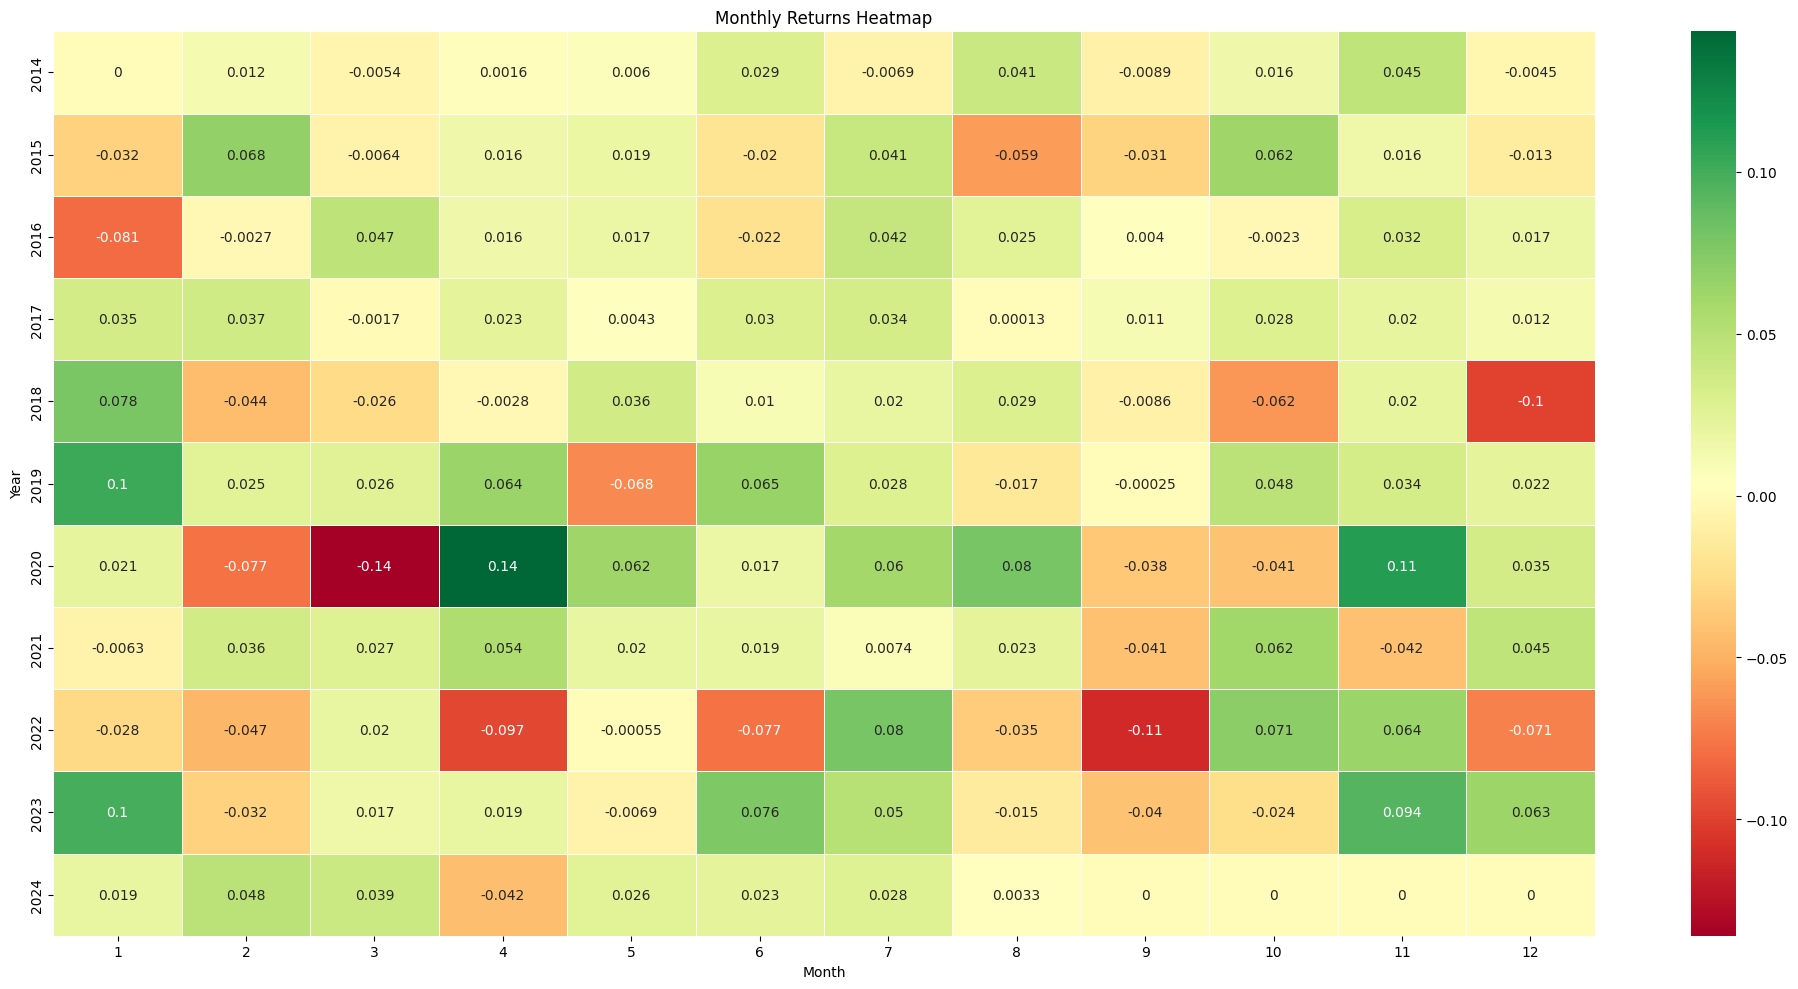

In [322]:
import seaborn as sns
import matplotlib.pyplot as plt



# Step 1: Create 'Year' and 'Week' columns
rp_monthly_ret['Year'] = rp_monthly_ret.index.year
rp_monthly_ret['Month'] = rp_monthly_ret.index.month

# Step 2: Pivot the DataFrame
rp_heatmap_data = rp_monthly_ret.pivot_table(index='Year', columns='Month', values='Return', aggfunc='mean')
rp_heatmap_data = rp_heatmap_data.apply(pd.to_numeric, errors='coerce').fillna(0)
# Step 3: Plot the heatmap
plt.figure(figsize=(20, 10))  # Increase the figure size
sns.heatmap(rp_heatmap_data, annot=True, linewidth=.5, cmap='RdYlGn')


# Adding titles and labels
plt.title('Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout() 
plt.show()